In [1]:
from pathlib import Path
from itertools import product
import h5py
import numpy as np
import einops as eo
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = False
import torch
import torchkbnufft as tkbn
from functorch import vmap

from src import preprocessing as pre
from src import io_utils as iou
from src import reconstruction as recon
from src import computation as comp
from src.density_compensation import *
from src.coil_sensitivity_estimation import *

%load_ext autoreload
%autoreload 2

In [46]:
from src.mapvbvd.mapVBVD import mapVBVD
# args = recon.nufft_CAPTURE_VarW_NQM_DCE_PostInj_Args_init(
datFileLocation=Path(
    '/data/anlab/PET_MOCO/PETMRdata/CAPTURE_DCE/ONC-DCE-004/meas_MID00165_FID04589_Abd_CAPTURE_FA15_Dyn.dat')
twixobj, mdh = mapVBVD(datFileLocation)
twixobj = twixobj[-1]

# args = recon.CAPTURE_VarW_NQM_DCE_PostInj_Args(
#         datFileLocation=Path(
#         '/data/anlab/PET_MOCO/PETMRdata/CAPTURE_DCE/ONC-DCE-004/meas_MID00165_FID04589_Abd_CAPTURE_FA15_Dyn.dat'),
#         last_slice=80
#         )
registered_vars, current_pos = pre.read_protocol(
    datFileLocation=datFileLocation, which_scan=-1)

shape_dict = dict(
    spoke_num=int(registered_vars['iNoOfFourierLines']),
    partition_num=int(registered_vars['lPartitions']),
    echo_num=int(registered_vars['NEcoMeas']))

# first read all mdh header
scan_meta_data_list, shape_dict = pre.read_scan_meta_data(
    datFileLocation, current_pos, shape_dict)
# now shape dict have spoke_num, partition_num, echo_num, ch_num, spoke_len

# args = recon.nufft_CAPTURE_VarW_NQM_DCE_PostInj_Args_init(
#     args, registered_vars, scan_meta_data_list, shape_dict)

   Config z <XProtocol> 
{  <ParamMap.""> 
  {
    <ParamMap."PARC"> 
    {      <ParamMap."HARDWARE"> 
      {        <ParamString."CPUCount">  { "12"  }
        <ParamString."MaxMemory">  { "42059"  }
        <ParamString."MaxRawObjectSize">  { "31643"  }
        <ParamString."MaxRawObjectSizePrioRecon">  { "1200"  }
        <ParamString."ProtectedSize">  { "1250"  }
        <ParamString."RAIDSize">  { "0"  }
        <ParamString."PDSFastSize">  { "0"  }
        <ParamString."PDSSaveSize">  { "0"  }
        <ParamString."NumberOfGPUs">  { "0"  }
      }
      <ParamMap."RECOMPOSE"> 
      {        <ParamString."PatientID">  { "xxxxxxxxxxx"  }
        <ParamString."PatientBirthDay">  { "xxxxxxxx"  }
        <ParamLong."PatientSex">  { 2  }
        <ParamString."tPatientName">  { "xxxxxxxxxxx"  }
        <ParamLong."SubProtocolIndex">  { }
        <ParamString."PatientLOID">  { "22.0.22713448"  }
        <ParamString."StudyLOID">  { "22.0.22713453"  }
        <ParamString."SeriesLOI

In [49]:
nav, kspace_data_raw = pre.read_navigator_kspace_data(
    args.datFileLocation, scan_meta_data_list, shape_dict)

# col_num, line_num, ch_num
nav = np.ascontiguousarray(nav[:, args.start_idx:args.spoke_num, :])
print(nav.shape,kspace_data_raw.shape)

100%|██████████| 96000/96000 [00:29<00:00, 3245.01it/s]

(640, 3000, 15) (640, 3000, 40, 15, 1)


In [119]:
twixobj.image.squeeze=True
data_raw = eo.rearrange(twixobj.image[''],'spoke_len ch_num spoke_num partition_num -> ch_num partition_num spoke_num spoke_len')

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


read data:   0%|          | 0/96000 [00:00<?, ?it/s]

In [121]:
kspace_data_raw =comp.normalization( data_raw[:,1:,:,:])
shape_dict = eo.parse_shape(kspace_data_raw, 'ch_num partition_num spoke_num spoke_len')
args = recon.CAPTURE_VarW_NQM_DCE_PostInj_Args(twixobj,mdh,shape_dict)
nav = eo.rearrange(data_raw[:,0,args.start_idx:,:], 'ch_num spoke_num spoke_len -> spoke_len spoke_num ch_num')
nav = comp.normalization(nav)
# shape of kspace_traj: complex_num_ch spoke_num spoke_len
kspace_traj_ = comp.generate_golden_angle_radial_spokes_kspace_trajctory(
    args.spoke_num, args.spoke_len)[:,args.start_idx:]
# ).narrow(dim=-2, start=args.spokes_to_skip, length=args.contra_num*args.spokes_per_contra)

# Generate respiratory curve with CAPTURE

In [122]:
ch, rotation, respiratory_curve = comp.tuned_and_robust_estimation(
    navigator=nav, percentW=args.percentW, Fs=args.Fs, FOV=args.FOV, ndata=args.spoke_len)
# separate the respiratory curve into different time periods (contrasts)
respiratory_curve_contrast = eo.rearrange(
    respiratory_curve[args.spokes_to_skip-args.start_idx:args.spokes_to_skip -args.start_idx+
                        args.contra_num*args.spokes_per_contra],
    '(contra spokes_per_contra) -> contra spokes_per_contra',
    contra=args.contra_num,
    spokes_per_contra=args.spokes_per_contra,
)
# in each of the contrast, we sort the respiratory curve in order to classify respiratory phases
sorted_r, args.sorted_r_idx = torch.sort(
    respiratory_curve_contrast, dim=-1)

Some tedious work to make the kspace data located in the middle of z-axis

In [123]:
# Wait for steady-state [make sure phase_num>=10]
kspace_data_selected = torch.from_numpy(
        kspace_data_raw)[:,:,args.start_idx:]
    # ).narrow(dim=-2, start=args.spokes_to_skip, length=args.contra_num*args.spokes_per_contra)
# kspace_data_selected = kspace_data_selected/kspace_data_selected.abs().max()
kspace_data_ = comp.centralize_kspace(
    kspace_data=kspace_data_selected,
    acquire_length=args.partition_num,
    full_length=args.slice_num,
    center_in_acquire_lenth=args.kspace_centre_partition_num, 
    dim=1)

kspace_data_z = comp.batch_process(batch_size=2, device=args.device)(
    comp.ifft_1D)(kspace_data_, dim=1)
kspace_data_for_nufft = torch.flip(kspace_data_z, dims=(1,))[
    :, args.first_slice:args.last_slice]

torch.Size([15, 80, 2990, 320])
torch.Size([15, 31, 2990, 320])
80 31


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Prepare nufft operator, kspace trajectory and kspace density compensation

In [124]:
# build nufft operators
# args.im_size = (640,640)
args.grid_size = (int(4*args.im_size[0]),int(4*args.im_size[1]))
adjnufft_ob = tkbn.KbNufftAdjoint(im_size=args.im_size,grid_size=args.grid_size).to(
    args.device)  # , grid_size=grid_size)


In [125]:
kspace_density_compensation_ = cihat_pipe_density_compensation(kspace_traj_,args.im_size,args.grid_size,device=args.device)
# kspace_data = kspace_data_for_nufft*kspace_density_compensation_


In [126]:
kspace_traj,  kspace_data = map(
    comp.data_binning,
    [kspace_traj_[:,args.spokes_to_skip-args.start_idx:args.spokes_to_skip-args.start_idx+args.contra_num*args.spokes_per_contra],  kspace_data_for_nufft[:,:,args.spokes_to_skip-args.start_idx:args.spokes_to_skip-args.start_idx+args.contra_num*args.spokes_per_contra]],
    [args.sorted_r_idx]*2, [args.contra_num]*2,
    [args.spokes_per_contra]*2, [args.phase_num]*2,
    [args.spokes_per_phase]*2)

In [127]:
print(kspace_data.shape,kspace_data_for_nufft.shape)

torch.Size([35, 5, 15, 80, 15, 320]) torch.Size([15, 80, 2990, 320])


# Coil Sensitivity Estimation

In [128]:
cse = Lowk_2D_CSE(
        # kspace_data_, kspace_traj_, adjnufft_ob, batch_size=2, device=args.device)
        kspace_data_*kspace_density_compensation_, kspace_traj_, adjnufft_ob,hamming_filter_ratio=0.05, batch_size=2, device=args.device)
        # TODO No density compensation for the CSE

100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


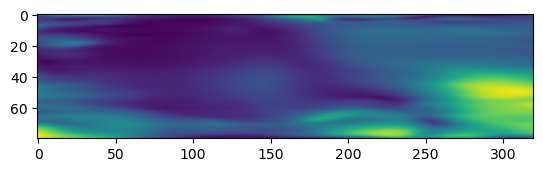

In [129]:
plt.imshow(cse.coil_sens[0,:,50,:].abs())

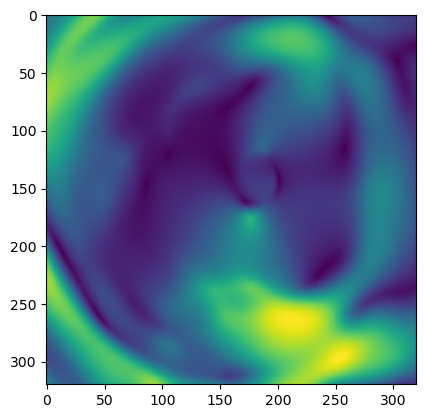

In [73]:
plt.imshow(cse.coil_sens[0,0,:,:].abs())

In [11]:
cse = Lowk_3D_CSE(
        kspace_data_*kspace_density_compensation_, kspace_traj_, adjnufft_ob,hamming_filter_ratio=[0.05,0.5], batch_size=2, device=args.device)

100%|██████████| 8/8 [00:20<00:00,  2.55s/it]


KeyboardInterrupt: 

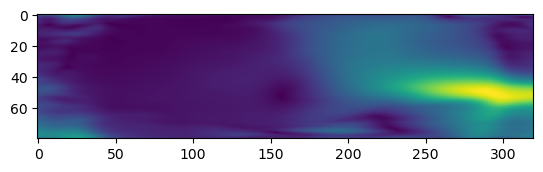

In [ ]:
plt.imshow(cse.coil_sens[0,:,80,:].abs())

In [ ]:
cse = Lowk_5D_CSE(kspace_data_,kspace_traj_,adjnufft_ob,args,voronoi_density_compensation,batch_size=2,device = args.device)

# DCE reconstruction

In [135]:
args.first_slice=50
args.last_slice=51
img = torch.zeros((args.contra_num, args.phase_num, args.last_slice -
                    args.first_slice, args.im_size[0], args.im_size[1]), dtype=torch.complex64)
for t, ph in product(range(args.contra_num), range(args.phase_num)):
    print('NUFFT for contrast:{}, phase:{}'.format(t, ph))
    sensitivity_map = cse[t, ph][:, args.first_slice:args.last_slice]
    img[t, ph, :, :, :] = \
        eo.reduce(
            comp.batch_process(batch_size=2, device=args.device)(comp.recon_adjnufft)(
                kspace_data[t, ph, :],#, args.first_slice:args.last_slice],
                sensitivity_map.to(torch.complex64),
                kspace_traj=kspace_traj[t, ph],
                adjnufft_ob=adjnufft_ob,
                density_compensation_func = voronoi_density_compensation)
            , 'ch slice w h -> slice w h', 'sum')[args.first_slice:args.last_slice]
    break
print('MCNUFFT reconstruction finished')
# img = (img-img.mean())/img.std()

NUFFT for contrast:0, phase:0


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

MCNUFFT reconstruction finished


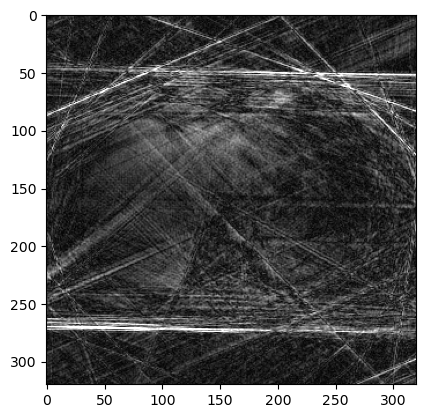

In [136]:
plt.imshow(comp.normalization(img[0,0,0].abs()).T,vmax=5,cmap='gray') #grid_size=3*

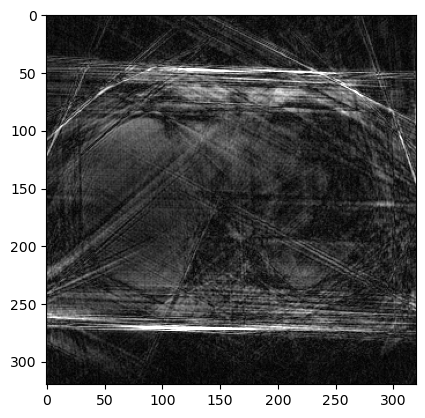

In [17]:
from nibabel import analyze
img_sihao = analyze.load('/data/anlab/PET_MOCO/PETMRdata/CAPTURE_DCE/ONC-DCE-004/Tra_MCNUFFT_MID00165_S1-80_np4W=80_5Phs_34Cont_S2T_Inj=30_Dur=340_TimePerCont=10.img')
# ni.save(img.numpy(), '/data/anlab/PET_MOCO/PETMRdata/CAPTURE_DCE/ONC-DCE-004/test.hdr')
img_sihao_normed = comp.normalization(np.flipud(img_sihao.get_fdata()[:,:,50,0].T))
plt.imshow(img_sihao_normed,vmax=5,cmap='gray')

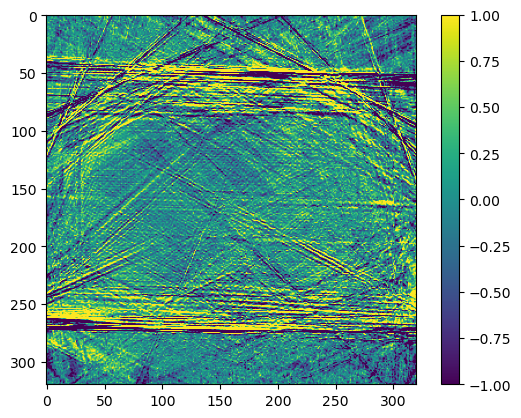

In [44]:
diff = torch.tensor(img_sihao_normed)-comp.normalization(img[0,0,0].abs().T)
plt.imshow(diff,vmin=-1,vmax=1)
plt.colorbar()

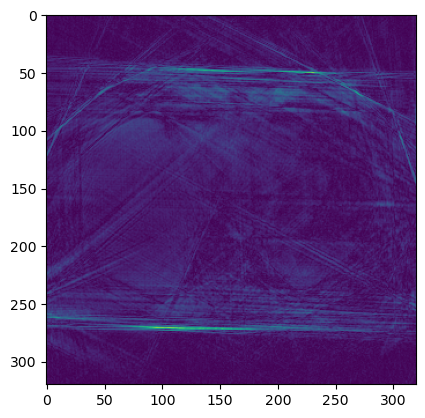

In [ ]:
plt.imshow(np.flipud(img_sihao.get_fdata()[:,:,50,0].T))

In [ ]:
with h5py.File('/data/anlab/PET_MOCO/PETMRdata/CAPTURE_DCE/ONC-DCE-004/test_lowk_3D.hdf5','w') as f:
    dset = f.create_dataset('im', data=img.abs().to(torch.float32))
# with h5py.File('/data/anlab/PET_MOCO/PETMRdata/CAPTURE_DCE/ONC-DCE-004/test_lowk_xy_jan_25.hdf5','w') as f:
    dset = f.create_dataset('cse', data=cse.coil_sens.abs().to(torch.float32))

In [ ]:
img_analyze = eo.rearrange(img, 't ph d w h -> w h (t ph d)', t = 34, ph=5, d=72)
# print(img_analyze.real.numpy().dtype)
img_obj = analyze.AnalyzeImage(img_analyze.flip((1,)).abs().numpy(), affine=None, dtype = np.float32)

img_obj.to_filename('/data/anlab/PET_MOCO/PETMRdata/CAPTURE_DCE/ONC-DCE-004/test_nufft_imsize_320_abs.img')

In [ ]:
img1 = img_sihao.dataobj[:,:,:12240,0]
img2 = img_obj.dataobj
img1 = (img1-img1.mean())/img1.std()
img2 = (img2-img2.mean())/img2.std()
diff = np.abs(img1-img2)
analyze.AnalyzeImage(diff,None,dtype = np.float32).to_filename('/data/anlab/PET_MOCO/PETMRdata/CAPTURE_DCE/ONC-DCE-004/test_diff_nufft_imsize_320_abs.img')

In [ ]:
plt.imshow(img.abs()[3,2,15])

NameError: name 'img_sihao' is not defined

In [ ]:
datFileLocation = Path(
        '/data/anlab/PET_MOCO/PETMRdata/CAPTURE_DCE/ONC-DCE-004/meas_MID00165_FID04589_Abd_CAPTURE_FA15_Dyn.dat')
firstSlice: int = 10
lastSlice: int = 80 #150
nPhases: int = 5
injectionTime: int = 30
durationToReconstruct: int = 340
timePerContrast: int = 10
lambdaFactorInterPhase: float = 0
lambdaFactorInterContrast: float = 0.05
lambdaFactorTGV_1stDerivative: float = 0.00375
bComputeSensitivities: bool = False
percentW: float = 12.5
cache_folder: Path = Path('.')/'cache'

fileName = datFileLocation.name  # xxx_CAPTURE_FA15_Dyn.dat
folderName = datFileLocation.parent
datFileName = datFileLocation.stem  # xxx_CAPTURE_FA15_Dyn
# os.chdir(folderName)

In [ ]:
registered_vars, current_pos = preprocessing.read_protocol(
    datFileLocation=datFileLocation, which_scan=-1)

shape_dict = dict(
    line_num=int(registered_vars['iNoOfFourierLines']), partition_num=int(registered_vars['lPartitions']), echo_num=int(registered_vars['NEcoMeas']))

# first read all mdh header
scan_meta_date_list, shape_dict = preprocessing.read_scan_meta_data(
    datFileLocation, current_pos, shape_dict)
# now shape dict have line_num, partition_num, echo_num, ch_num, col_num

nav, kSpaceData = preprocessing.read_navigator_kspace_data(
    datFileLocation, scan_meta_date_list, shape_dict)

100%|██████████| 96000/96000 [00:30<00:00, 3199.67it/s]


In [ ]:
# get channel number
"""
s1 = 'dRawDataCorrectionFactorIm';
ind1 = strfind(AAA',s1);
ind1 = ind1(1);
s2 = 'Method."ComputeScan">';
ind2 = strfind(AAA',s2);
ind2 = ind2(find(ind2>ind1,1));
textOfInterest = AAA(ind1+200:ind2)';
indQuote = strfind(textOfInterest,'"');
indQuote = reshape(indQuote,[2,length(indQuote)/2]);
clear coilIDs
for k = 1:size(indQuote,2)
    coilIDs{k} = char(textOfInterest(indQuote(2*(k-1)+1)+1:indQuote(2*k)-1));
end
disp(coilIDs)
numberOfChannels = length(coilIDs); 
"""
# TODO this matlab method reads out 39 channels, but I find 42 channel in AAA

ch_num = shape_dict['ch_num']
col_num = shape_dict['col_num']
ntviews = int(registered_vars['lRadialViews'])
nParMeas = registered_vars['NParMeas']
numberOfSlices = registered_vars['lImagesPerSlab']
sliceOverSampleing = registered_vars[('sKSpace', 'dSliceOversamplingForDialog')]
numberOfSlices = round(numberOfSlices*(1+sliceOverSampleing))
kspace_centre_partition_num = scan_meta_date_list[-1]['kspace_centre_partition_num']

# next we check the validity of input first slice and last slice
assert lastSlice <= numberOfSlices , f"Try to set {lastSlice=} <= {numberOfSlices=}"
assert firstSlice < numberOfSlices , f"Try to set {firstSlice=} < {numberOfSlices=}"
assert lastSlice > firstSlice , f"Try to set {lastSlice=} > {firstSlice=}"

FOV = registered_vars['RoFOV']
ndata = 2*registered_vars['NImageLins'] # TODO what is this used for? the same as column number?

# iou.search_for_keywords_in_AAA(registered_vars,'SliceThickness') 
# TODO didn't find this argument
# sliceThickness = 1/numberOfSlices*registered_vars['SliceThickness'] 
isSAG = registered_vars['lSag'] 
isCor = registered_vars['lCor'] 
isTra = (not isSAG) and (not isCor)

# Read TR from raw data
# iou.search_for_keywords_in_AAA(registered_vars,'alTR')
# print(registered_vars[('alTR', '0')])
TR = registered_vars[('alTR', '0')]/1000
T = TR*nParMeas*1e-3+18.86e-3 # 19e-3 is for Q-fat sat
Fs = 1/T

In [ ]:
start_idx = max(max(nPhases,10),nPhases*np.ceil(10/nPhases)) # TODO what this means???
K = np.ascontiguousarray(nav[:,start_idx:ntviews,:]) # col_num, line_num, ch_num
print(K.flags['C_CONTIGUOUS'])

# To reduce noise, the navigator k-space data were apodized using a Hamming window.
nonzero_width = int( K.shape[0]*percentW/100 ) # col_num, line_num, ch_num
pad_width_L = int( (K.shape[0]-nonzero_width)//2 )
pad_width_R = int(K.shape[0]-nonzero_width-pad_width_L)

hamming_weights = np.hamming(nonzero_width)
W = np.pad(hamming_weights,pad_width=(pad_width_L,pad_width_R)) 
W = eo.repeat(W, 'col_num -> col_num line_num ch_num', line_num = K.shape[1], ch_num = K.shape[2])

True


In [ ]:
# New quality metric block begin
import torch
from torch.fft import ifftshift,ifft,fftshift,fft
N = K.shape[1]
f = torch.linspace(-0.5*Fs,0.5*Fs-Fs/N,steps=N).cuda()
# compute the ifft of weighted navigator, using the representation in CAPTURE paper
# col_num->x, line_num->n, ch_num->i, tuning_num->m
K_weighted = torch.asarray(W*K,device=f.device)
projections = fftshift(ifft(ifftshift(K_weighted, dim=0),dim=0),dim=0) # shape is x n i

phase_rotation_factors = torch.exp(-1j*2*torch.pi*torch.arange(1,101,device=f.device)/100) # shape is m=100
r = torch.empty((projections.shape[1],projections.shape[2],100),device=f.device)
for m in range(100):
    r[:,:,m] = torch.argmax((phase_rotation_factors[m]*projections[:,:,:]).real,dim=0)
# A = torch.einsum('xni,m->xnim',projections,phase_rotation_factors).real # np.multiply.outer(projections, phase_rorate..)
# r = torch.argmax(A,dim=0).to(torch.double)+1 # 'x n i m -> n i m'
R = torch.abs(fftshift(fft(r-eo.reduce(r, 'n i m -> i m', 'mean'),dim = 0),dim=0))

lowfreq_integral = eo.reduce(R[(torch.abs(f)<0.5) * (torch.abs(f)>0.1)], 'f i m -> i m', 'sum')
highfreq_integral = eo.reduce(R[torch.abs(f)>0.8], 'f i m -> i m', 'sum')
r_range = eo.reduce(r,'n i m -> i m', 'max')-eo.reduce(r,'n i m -> i m', 'min')
lower_bound = torch.full_like(r_range,30/(FOV/(ndata/2)))
determinator = torch.maximum(r_range,lower_bound) # what does this FOV/ndata use for
Q = lowfreq_integral/highfreq_integral/determinator
Q_np = Q.numpy(force=True)
# faster than matlab version 10x

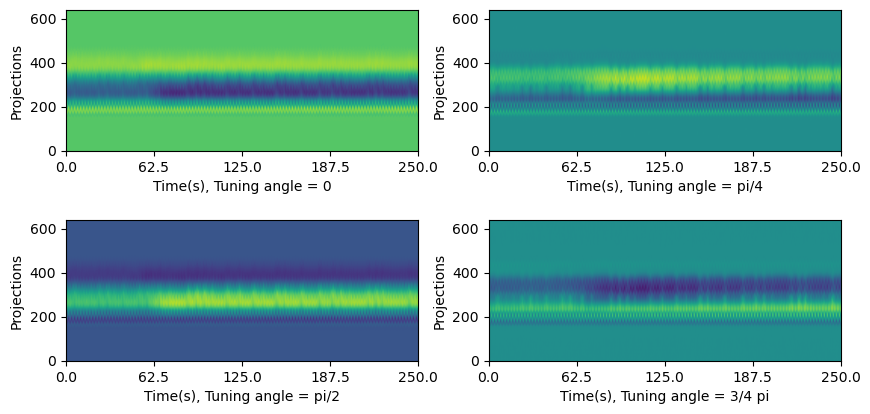

In [ ]:
figure,axes = plt.subplots(2,2,figsize=(10,5))
# print(projections[:,:100,7].shape,r[:100,7,18])
im_length = 1600
def interp_r(input,length):
    x = np.arange(input.shape[0])
    y = input
    x_interp = np.arange(length)*input.shape[0]/length
    y_interp = np.interp(x_interp,x,y,)
    return x_interp,y_interp

axes[0,0].imshow(projections[:,:1600,7].numpy(force=True).real,extent = [0, 1600, 0, 640])
axes[0,0].set_xticks(ticks=np.arange(5)*400 ,labels = np.arange(5)/4*250)
axes[0,0].set_xlabel('Time(s), Tuning angle = 0')
axes[0,0].set_ylabel('Projections')
axes[0,1].imshow((phase_rotation_factors[25]*projections[:,:1600,7]).real.numpy(force=True),extent = [0, 1600, 0, 640])
axes[0,1].set_xticks(ticks=np.arange(5)*400 ,labels = np.arange(5)/4*250)
axes[0,1].set_xlabel('Time(s), Tuning angle = pi/4')
axes[0,1].set_ylabel('Projections')
axes[1,0].imshow((phase_rotation_factors[49]*projections[:,:1600,7]).real.numpy(force=True),extent = [0, 1600, 0, 640])
axes[1,0].set_xticks(ticks=np.arange(5)*400 ,labels = np.arange(5)/4*250)
axes[1,0].set_xlabel('Time(s), Tuning angle = pi/2')
axes[1,0].set_ylabel('Projections')
axes[1,1].imshow((phase_rotation_factors[74]*projections[:,:1600,7]).real.numpy(force=True),extent = [0, 1600, 0, 640])
axes[1,1].set_xticks(ticks=np.arange(5)*400 ,labels = np.arange(5)/4*250)
axes[1,1].set_xlabel('Time(s), Tuning angle = 3/4 pi')
axes[1,1].set_ylabel('Projections')
plt.savefig('fig1a',dpi=400)
# axes[0,1].imshow(projections[:,:600,7].numpy(force=True).imag)
# axes[1,0].imshow(np.abs( projections[:,:600,7].numpy(force=True)))
# axes[1,1].imshow(np.angle( projections[:,:600,7].numpy(force=True)))
# axes[0,0]

0.007908126
0.007908126
torch.Size([2990, 15, 100])
0 52
(15, 100)


Text(0.5, 1.0, 'Channel 8 Quality metric')

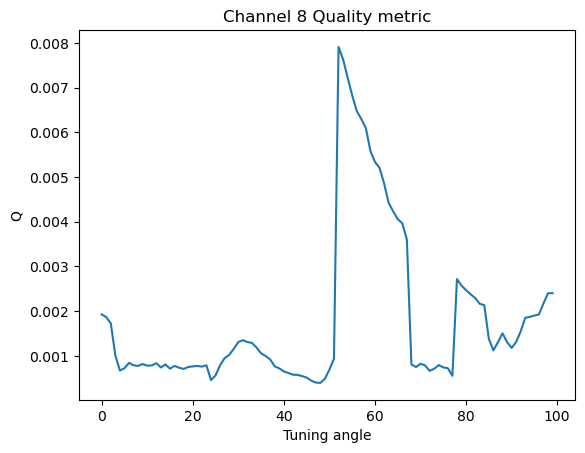

In [ ]:
i_max, m_max = np.unravel_index(np.argmax(Q_np,axis=None),Q_np.shape)
print(Q_np.max())
print(Q_np[i_max,m_max])
projection_max = projections[:,:,i_max].numpy(force=True)
r_max = r[:,i_max,m_max].numpy(force=True)
print(r.shape)
# matlab file line 493
print(i_max,m_max)
print(Q_np.shape)
plt.plot(Q_np[i_max,:])
# plt.imshow(Q_np[:,:])
# plt.plot(r_max_filtered[:time_length],color='r',linewidth=0.8)
# plt.xticks(ticks=np.arange(9)*200 ,labels = np.arange(9)/8*250)
plt.xlabel('Tuning angle')
# plt.ylabel('Channel')
plt.ylabel('Q')
plt.title('Channel 8 Quality metric')
# plt.legend('r ch = 7, alpha = 18')

Text(0.5, 0, 'Freq, m=75/100 pi')

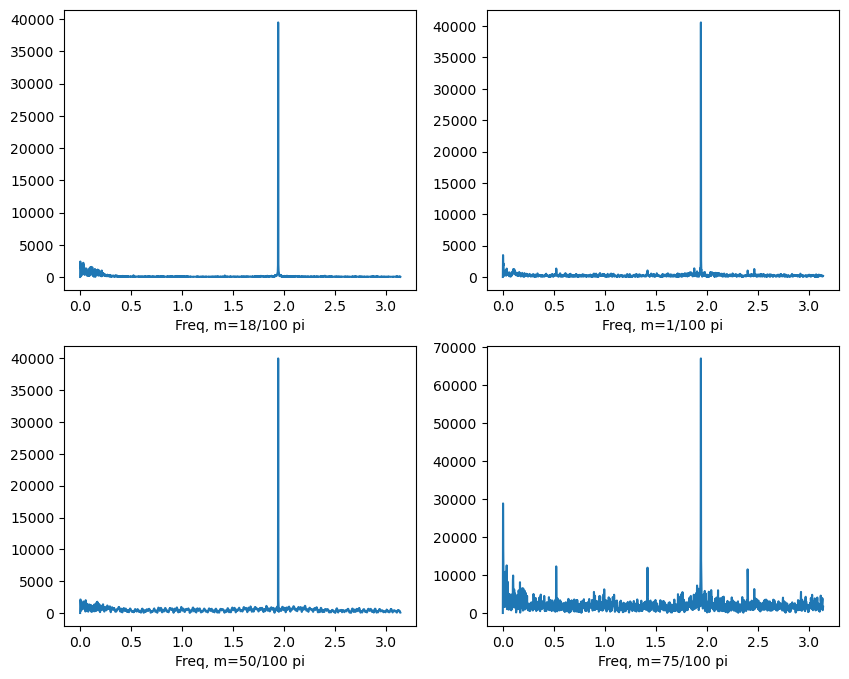

In [ ]:
figure,axes = plt.subplots(2,2,figsize=(10,8))
# print(projections[:,:100,7].shape,r[:100,7,18])
im_length = 1600

axes[0,0].plot(np.linspace(0,1,R.shape[0]//2)*np.pi,R[R.shape[0]//2:,i_max,m_max].numpy(force=True))
axes[0,0].set_xlabel('Freq, m={}/100 pi'.format(m_max))
axes[0,1].plot(np.linspace(0,1,R.shape[0]//2)*np.pi,R[R.shape[0]//2:,i_max,0].numpy(force=True))
axes[0,1].set_xlabel('Freq, m=1/100 pi')
axes[1,0].plot(np.linspace(0,1,R.shape[0]//2)*np.pi,R[R.shape[0]//2:,i_max,50].numpy(force=True))
axes[1,0].set_xlabel('Freq, m=50/100 pi')
axes[1,1].plot(np.linspace(0,1,R.shape[0]//2)*np.pi,R[R.shape[0]//2:,i_max,75].numpy(force=True))
axes[1,1].set_xlabel('Freq, m=75/100 pi')
# axes[0,1].set_xlabel('Time(s), Tuning angle = pi/4')
# axes[0,1].set_ylabel('Projections')
# axes[1,0].imshow((phase_rotation_factors[49]*projections[:,:1600,7]).real.numpy(force=True),extent = [0, 1600, 0, 640])
# axes[1,0].set_xticks(ticks=np.arange(5)*400 ,labels = np.arange(5)/4*250)
# axes[1,0].set_xlabel('Time(s), Tuning angle = pi/2')
# axes[1,0].set_ylabel('Projections')
# axes[1,1].imshow((phase_rotation_factors[74]*projections[:,:1600,7]).real.numpy(force=True),extent = [0, 1600, 0, 640])
# axes[1,1].set_xticks(ticks=np.arange(5)*400 ,labels = np.arange(5)/4*250)
# axes[1,1].set_xlabel('Time(s), Tuning angle = 3/4 pi')
# axes[1,1].set_ylabel('Projections')
# plt.savefig('fig1a',dpi=400)

In [ ]:
import scipy
b = scipy.signal.firwin(12,1/(Fs/2), window = "hamming", pass_zero = 'lowpass')
a = 1
r_max_low_pass = scipy.signal.filtfilt(b,a,r_max)
r_max_SG = scipy.signal.filtfilt(b,a, scipy.signal.savgol_filter(r_max,5,1))
r_max_filtered = r_max_low_pass.copy()
r_max_filtered[0:10],r_max_filtered[-10:] =r_max_SG[0:10] , r_max_SG[-10:]



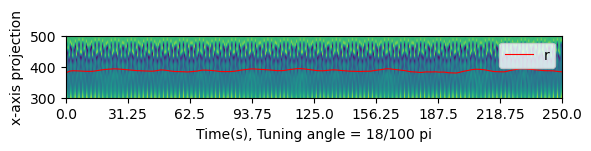

In [ ]:
plt.gca().set_aspect('equal')
im_length = 1600
time_length = 400
plt.imshow((phase_rotation_factors[m_max]*projections[:,:time_length,i_max]).real.numpy(force=True),extent = [0, 1600, 0, 640])
plt.plot(interp_r(r_max_filtered[:time_length],im_length)[1],color='r',linewidth=0.8)
# plt.plot(r_max_filtered[:time_length],color='r',linewidth=0.8)
plt.xticks(ticks=np.arange(9)*200 ,labels = np.arange(9)/8*250)
plt.ylim(300,500)
plt.xlabel('Time(s), Tuning angle = 18/100 pi')
plt.ylabel('x-axis projection')
plt.legend('r ch = {}, alpha = {}'.format(i_max,m_max))
plt.savefig('fig1b',dpi=400)

In [ ]:
from tqdm import tqdm
def batch_process(batch_size, dimensions, device):
    def Inner(func):
        def process(*args, **kwargs):
            batch_dim_length = args[0].shape[0]
            batch_start_idx = torch.arange(0, batch_dim_length, batch_size)
            batch_end_idx = batch_start_idx+batch_size
            batch_end_idx[-1] = batch_dim_length
            batch_indices = list(zip(batch_start_idx,batch_end_idx))
            outputs = []
            kwargs_input = dict((k,v.to(device)) for k,v in kwargs.items())
            for start,end in tqdm(batch_indices):
                args_input = (data[start:end].to(device) for data in args)
                output_on_device = func(*args_input, **kwargs_input)
                outputs.append(output_on_device.cpu())
            outputs = torch.concatenate(outputs,dim=0)
            for k,v in kwargs_input.items():
                v.cpu()
            return outputs
        return process 
    return Inner

In [ ]:
# the number of slices after CS reconstruction
nslc_f = numberOfSlices # 80
# the number of slices acquired/before CS reconstruction
nslc = int( nParMeas ) # 32;

# the slice with kz=0
# islc_center = 15; % 1-based. In the MDH, the central partition no is 14.
islc_center = kspace_centre_partition_num

# IMPORTANT!!! Speed up processing by allocating only needed memory.
# Deleting chunks of data from the 4D matrix takes a long time!
# selected_spikes = np.arange(max(nPhases,10),ntviews) # Wait for steady-state [make sure nPhases>=10]
# selected_partitions = np.arange(1,nslc)

gpu = torch.device('cuda')
cpu = torch.device('cpu')

diff_kdata = int(nslc_f // 2  - islc_center)
print(diff_kdata,nslc)
selected_kSpaceData = torch.from_numpy(kSpaceData[:, max(nPhases,10):ntviews, 1:nslc,:,0])
kSpaceData_t = torch.zeros(int(ndata), ntviews-max(nPhases,10), nslc_f, ch_num, dtype=torch.complex64)

# skip diff_kdata is to skip navigator.
# everytime when partition=0, there is a navigator
kSpaceData_t[:,:,diff_kdata:nslc+diff_kdata,:] = selected_kSpaceData
kSpaceData_t = eo.rearrange(kSpaceData_t, 'col_num line_num slice_num ch_num -> ch_num line_num col_num slice_num')
print('Start iFFTz')
batch_size= 3
@batch_process(batch_size = batch_size, dimensions=4, device=gpu)
def slice_axis_ifft(kspace):
    kSpaceData_t_ch_gpu = fftshift(ifft(ifftshift(kspace, dim=-1),dim=-1),dim=-1 )
    return kSpaceData_t_ch_gpu
    kSpaceData_t[:,:,:,start:end] = kSpaceData_t_ch_gpu

kSpaceData_t = slice_axis_ifft(kSpaceData_t)
max_abs_value_in_kspace = kSpaceData_t.abs().max()
kSpaceData_t = torch.flip(kSpaceData_t,dims=(-1,)) # TODO why we need filp?
kSpaceData_t = kSpaceData_t/max_abs_value_in_kspace # TODO TGV? 
kSpaceData_t_for_kbnufft = eo.rearrange(kSpaceData_t, 'ch_num line_num col_num slice_num -> slice_num ch_num line_num col_num')

28 32
Start iFFTz


100%|██████████| 5/5 [00:34<00:00,  6.84s/it]


In [ ]:
print('Getting radial spokes')
# calculate the density function for nufft reconstruction of all spokes
def generate_radial_spokes_kspace_trajctory(spokes_num, spoke_length):
    # create a k-space trajectory
    ga = torch.tensor(np.deg2rad(180 / ((1 + np.sqrt(5)) / 2)))
    kx = torch.zeros(spokes_num, spoke_length)
    ky = torch.zeros_like(kx)
    ky[0, :] = torch.linspace(-torch.pi, torch.pi, spoke_length)
    for i in range(1, spokes_num):
        kx[i, :] = torch.cos(ga) * kx[i - 1, :] - torch.sin(ga) * ky[i - 1, : ]
        ky[i, :] = torch.sin(ga) * kx[ i - 1,:] + torch.cos(ga) * ky[ i - 1, :]
        
    ktraj = torch.stack((ky, kx), dim=0)
    return ktraj
ntviews = int( ntviews )
ndata = int(ndata)
ktraj = generate_radial_spokes_kspace_trajctory(ntviews,ndata)

import torchkbnufft as tkbn
ktraj = ktraj[:,max(nPhases,10):,:] # throw away first 10 samples
print('ktraj shape: {}'.format(ktraj.shape))

# build nufft operators
# im_size = (ndata//2,ndata//2)
im_size = (ndata,ndata)
# grid_size = (ndata,ndata)
# nufft_ob = tkbn.KbNufft(im_size=im_size, grid_size=grid_size)
# adjnufft_ob = tkbn.KbNufftAdjoint(im_size=im_size, grid_size=grid_size)
nufft_ob = tkbn.KbNufft(im_size=im_size)#, grid_size=grid_size)
adjnufft_ob = tkbn.KbNufftAdjoint(im_size=im_size)#, grid_size=grid_size)

print(nufft_ob)
print(adjnufft_ob)

k_space_density_compensation = tkbn.calc_density_compensation_function(ktraj=eo.rearrange(ktraj,'c spoke_num spoke_len -> c (spoke_num spoke_len)'), im_size=im_size)
# image_sharp = adjnufft_ob(kdata * dcomp, ktraj, smaps=smap)

Getting radial spokes
ktraj shape: torch.Size([2, 2990, 640])

KbNufft
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (640, 640)


KbNufftAdjoint
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (640, 640)



In [ ]:
### compute coil sensitivity estimation ###
nonzero_width = int(ndata*5/100) # col_num, line_num, ch_num
pad_width_L = int((ndata-nonzero_width)//2 )
pad_width_R = int(ndata-nonzero_width-pad_width_L)

hamming_weights = np.hamming(nonzero_width)
W = np.pad(hamming_weights,pad_width=(pad_width_L,pad_width_R)) 
spoke_lowpass_filter = torch.from_numpy(W)
# spoke_lowpass_filter = eo.repeat(torch.from_numpy(W), 'col_num -> slice_num ch_num line_num col_num', line_num = kSpaceData_t.shape[1], slice_num = lastSlice-firstSlice, ch_num = kSpaceData_t.shape[3])

# img_nufft = np.zeros((ndata // 2, ndata // 2, lastSlice-firstSlice))
# img_nufft = np.zeros((ndata, ndata, lastSlice-firstSlice))

batch_size = 2
torch.cuda.empty_cache() 
@batch_process(batch_size = batch_size, dimensions=4, device=gpu)
def xy_plain_adjnufft(kspace_data, spoke_lowpass_filter, k_space_density_compensation , ktraj, adjnufft_obj):
    kSpaceData_t_lowpass = spoke_lowpass_filter*kspace_data
    kSpaceData_t_lowpass = eo.rearrange(kSpaceData_t_lowpass, 'slice_num ch_num line_num col_num -> slice_num ch_num (line_num col_num)').contiguous()
    img_dc = adjnufft_ob.forward(kSpaceData_t_lowpass*k_space_density_compensation, ktraj)
    return img_dc

img_dc = xy_plain_adjnufft(
    kSpaceData_t_for_kbnufft[firstSlice:lastSlice,:,:,:], 
    spoke_lowpass_filter=spoke_lowpass_filter,
    k_space_density_compensation = k_space_density_compensation, 
    ktraj=eo.rearrange(ktraj,'c spoke_num spoke_len -> c (spoke_num spoke_len)'),
    adjnufft_obj=adjnufft_ob)
img_sens_SOS = torch.sqrt(eo.reduce(img_dc.abs()**2, 'slice_num ch_num height width -> slice_num () height width', 'sum'))
img_sens = img_dc/img_sens_SOS

100%|██████████| 35/35 [00:22<00:00,  1.53it/s]


torch.Size([70, 15, 640, 640])


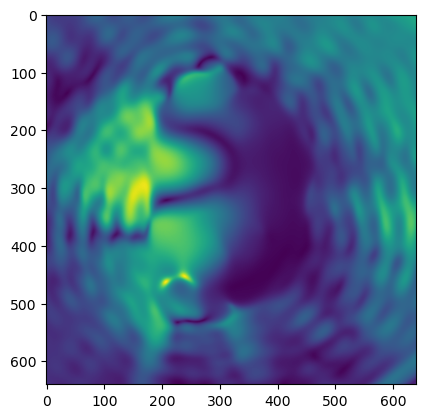

In [ ]:
print(img_sens.shape)
plt.imshow(torch.flip(img_sens[35,0].abs(),dims=(1,)))

torch.Size([70, 15, 320, 320])


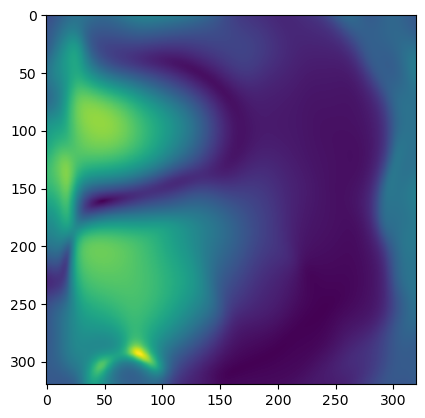

In [ ]:
print(img_sens.shape)
plt.imshow(torch.flip(img_sens[35,0].abs(),dims=(1,)))

In [ ]:
### DCE recon ###
nSpokesToWorkWith = np.floor(durationToReconstruct/T)
# nSpokesToSkip = round(injectionTime/T)-max(nPhases,10); # Exclude the first 10 prep spokes
# CHANGE: Go backward to obtain a "pre". Therefore, we will subtract time
# per contrast from injection time. (Jan )
nSpokesToSkip = round((injectionTime-timePerContrast)/T)-max(nPhases,10) # Exclude the first 10 prep spokes
nSpokesPerContrast = np.floor(timePerContrast/T)
nSpokesPerContrast = int(nSpokesPerContrast-np.mod(nSpokesPerContrast,nPhases))
nContrasts = int(np.floor(nSpokesToWorkWith/nSpokesPerContrast))
nPhases = int(nPhases)
n_spoke_per_phase = int( nSpokesPerContrast/nPhases )

r_max_filtered_contrast = eo.rearrange(
    torch.tensor( r_max_filtered[nSpokesToSkip:nSpokesToSkip+nContrasts*nSpokesPerContrast] ), 
    '(contra n_spoke_per_contra) -> contra n_spoke_per_contra',
    contra = nContrasts,
    n_spoke_per_contra = nSpokesPerContrast,
    )
sorted_r, sorted_r_idx = torch.sort(r_max_filtered_contrast,dim = -1)


tensor([64, 65, 63, 66, 62, 31, 30, 32, 29, 28, 61, 67, 27, 33, 26, 60, 68, 34,
        25, 59, 24, 69, 35, 58, 23, 70, 57, 36, 22, 71, 75, 72, 21, 74, 56, 73,
         1, 37, 20,  2, 38, 55, 19, 18, 39, 54, 17,  3, 16, 40, 15, 53, 14,  4,
        13, 41, 52, 12,  5, 51, 11, 42,  6, 10, 50,  9,  7,  8, 43, 49, 44, 48,
        45, 47, 46])


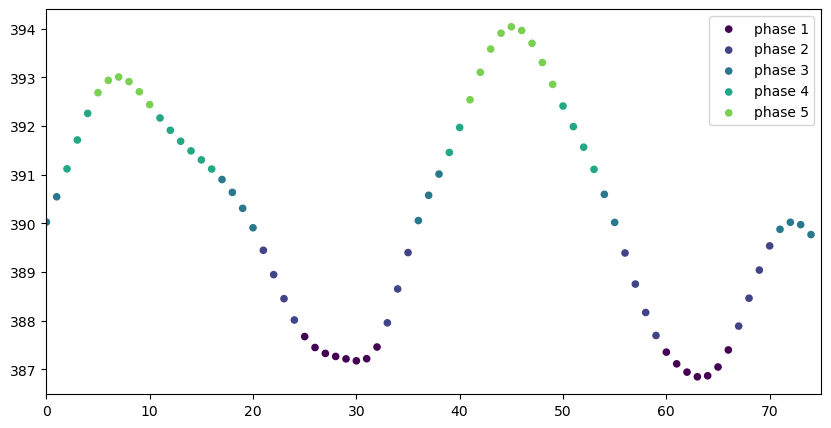

In [ ]:
figure,axes = plt.subplots(1,1,figsize=(10,5))
sorted_r_ = eo.rearrange(
    sorted_r, 
    'contra (phase n_spoke_per_phase) ->contra phase n_spoke_per_phase',
    phase = nPhases,
    n_spoke_per_phase = n_spoke_per_phase)
sorted_r_idx_ = eo.rearrange(
    sorted_r_idx, 
    'contra (phase n_spoke_per_phase) ->contra phase n_spoke_per_phase',
    phase = nPhases,
    n_spoke_per_phase = n_spoke_per_phase)
for con in range( sorted_r.shape[0] ):
    color = ['b','g','r','c','m']
    for ph in range(nPhases):
        plt.scatter(
            75*con+sorted_r_idx_[con,ph],
            sorted_r_[con,ph],
            s = 20*np.ones(sorted_r_.shape[2]),
            c = ph*np.ones(sorted_r_.shape[2]), vmin=0,vmax=5)#color[ph])
    break
plt.legend(['phase {}'.format(ph+1) for ph in range(5)])
plt.xlim(0,75)
print(sorted_r_idx[0]+1)
# print(sorted_r[0,:])print(sorted_r.shape)

In [ ]:
ktraj_recon = eo.rearrange(
    ktraj[:,nSpokesToSkip:nSpokesToSkip+nContrasts*nSpokesPerContrast,:], 
    'c (contra spoke_per_contra) spoke_len -> c contra spoke_per_contra spoke_len ',
    contra = nContrasts,
    spoke_per_contra = nSpokesPerContrast)
# print(sorted_r_idx[0,:])
# print(sorted_r[0,:])
ktraj_recon = ktraj_recon.gather(
    dim=-2, 
    index = eo.repeat(
        sorted_r_idx, 
        'contra n_spoke_per_contra -> c contra n_spoke_per_contra spoke_len',
        c=2,
        contra = nContrasts,
        n_spoke_per_contra = nSpokesPerContrast,
        spoke_len = ndata)
    )
ktraj_recon = eo.rearrange(
    ktraj_recon, 
    'c t (ph spoke) spoke_len -> c t ph spoke spoke_len',
    ph = nPhases,
    spoke = n_spoke_per_phase)
print(ktraj_recon.shape)

###### TODO reorder k_space_density_compensation, kspace_data...

# sorted_r = eo.rearrange(
#     sorted_r, 
#     'contra (phase n_spoke_per_phase) ->contra phase n_spoke_per_phase',
#     phase = nPhases,
#     n_spoke_per_phase = n_spoke_per_phase)
# print(sorted_r_idx[0])
# print(sorted_r[0,:])

torch.Size([2, 34, 5, 15, 640])


In [ ]:
def data_binning(input, sorted_r_idx):
    output = eo.rearrange(
        input, 
        '... (t spoke_per_contra) spoke_len -> ... t spoke_per_contra spoke_len ',
        t = nContrasts,
        spoke_per_contra = nSpokesPerContrast
        )
    output = output.gather(
        dim=-2, 
        index = 
        eo.repeat(
            sorted_r_idx, 
            't n_spoke_per_contra -> t n_spoke_per_contra spoke_len',
            # t = nContrasts,
            n_spoke_per_contra = nSpokesPerContrast,
            spoke_len = ndata).expand_as(output)
    )
    output = eo.rearrange(
        output, 
        '... t (ph spoke) spoke_len -> ... t ph spoke spoke_len',
        ph = nPhases,
        spoke = n_spoke_per_phase)
    return output

ktraj_recon = data_binning(ktraj[:,nSpokesToSkip:nSpokesToSkip+nContrasts*nSpokesPerContrast,:],sorted_r_idx)

# k_space_density_compensation is not cropped on contrast(time) axis, it is flattened, now recover it
k_space_density_compensation_ = eo.rearrange(
    k_space_density_compensation, 
    'b ch (spokes_num spoke_len) -> b ch spokes_num spoke_len ',
    b=1,
    ch=1,
    spokes_num = ntviews-max(nPhases,10),
    spoke_len = ndata)[:,:,nSpokesToSkip:nSpokesToSkip+nContrasts*nSpokesPerContrast,:]
    # (contra spoke_per_contra)

k_space_density_compensation_ = data_binning(k_space_density_compensation_,sorted_r_idx)

# change kspace data into shapes like slice, ch, contrast, phase, spoke, spoke_len
kspace_data = data_binning(kSpaceData_t_for_kbnufft[firstSlice:lastSlice,:,nSpokesToSkip:nSpokesToSkip+nContrasts*nSpokesPerContrast,:],sorted_r_idx)
# kspace_data = eo.rearrange(

#     's ch (t ph spoke) spoke_len -> s ch t ph spoke spoke_len ',
#     t = nContrasts,
#     ph = nPhases,
#     spoke = n_spoke_per_phase
# )
kspace_data_compensated = k_space_density_compensation_*kspace_data



  0%|          | 0/70 [00:04<?, ?it/s]

finished
torch.Size([170, 70, 320, 320])
tensor(0., dtype=torch.float64)


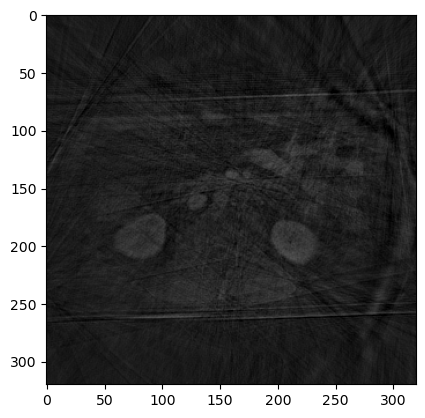

In [ ]:
batch_size = 8
torch.cuda.empty_cache() 
@batch_process(batch_size = batch_size, dimensions=4, device=gpu)
def recon_adjnufft(data, ktraj, smaps, adjnufft_obj):
    img_dc = adjnufft_ob.forward(data, ktraj, smaps=smaps)
    return img_dc

img_nufft = torch.zeros((nContrasts*nPhases,lastSlice-firstSlice,int(ndata/2),int(ndata/2)),dtype=torch.complex64)
for slice_idx in tqdm(range(lastSlice-firstSlice)):
    if slice_idx in [0]:
        output = recon_adjnufft(
            eo.rearrange(
                kspace_data_compensated[slice_idx],
                'ch t ph spoke spoke_len-> (t ph) ch (spoke spoke_len)'
            ),
            eo.rearrange(ktraj_recon,
            'c t ph spoke spoke_len -> (t ph) c (spoke spoke_len)'), # c stands for complex channel
            # k_space_density_compensation = k_space_density_compensation, 
            smaps=img_sens[slice_idx],
            adjnufft_obj=adjnufft_ob)[:,:,int(ndata/4):3*int(ndata/4),int(ndata/4):3*int(ndata/4)]
        img_nufft[:,slice_idx,:,:] = eo.reduce(output, 'b ch w h -> b w h', 'sum')
        break
    # img_nufft[:,slice_idx,:,:] = eo.reduce(output, 'b ch w h -> b w h', 'sum')
print('finished')
        # break
print(img_nufft.shape)
print(img_nufft[60,34].real.max())
plt.imshow(img_nufft[35,0].real.T, cmap = 'gray', vmin=-0.01,vmax=0.09)


  0%|          | 0/70 [00:03<?, ?it/s]

finished
torch.Size([170, 70, 320, 320])
tensor(-0.0191, dtype=torch.float64)


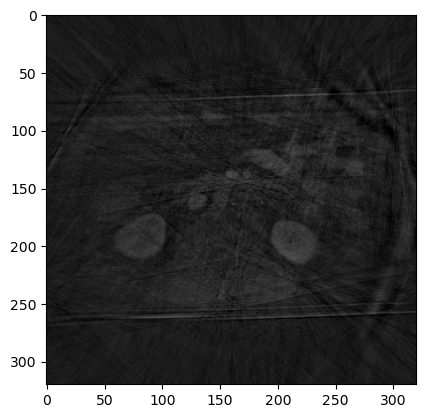

In [ ]:

batch_size = 8
torch.cuda.empty_cache() 
@batch_process(batch_size = batch_size, dimensions=4, device=gpu)
def recon_adjnufft(data, ktraj, smaps, adjnufft_obj):
    img_dc = adjnufft_ob.forward(data, ktraj, smaps=smaps)
    return img_dc

img_nufft = torch.zeros((nContrasts*nPhases,lastSlice-firstSlice,int(ndata/2),int(ndata/2)),dtype=torch.complex64)
for slice_idx in tqdm(range(lastSlice-firstSlice)):
    if slice_idx in [0]:
        output = recon_adjnufft(
            eo.rearrange(
                kspace_data_compensated[slice_idx],
                'ch t ph spoke spoke_len-> (t ph) ch (spoke spoke_len)'
            ),
            eo.rearrange(ktraj_recon,
            'c t ph spoke spoke_len -> (t ph) c (spoke spoke_len)'), # c stands for complex channel
            # k_space_density_compensation = k_space_density_compensation, 
            smaps=img_sens[slice_idx],
            adjnufft_obj=adjnufft_ob)#[:,:,int(ndata/4):3*int(ndata/4),int(ndata/4):3*int(ndata/4)]
        img_nufft[:,slice_idx,:,:] = eo.reduce(output, 'b ch w h -> b w h', 'sum')
        print('finished')
        break
    # img_nufft[:,slice_idx,:,:] = eo.reduce(output, 'b ch w h -> b w h', 'sum')

print(img_nufft.shape)
print(img_nufft[35,0].real.min())
plt.imshow(img_nufft[35,0].real.T, cmap = 'gray', vmin=-0.01,vmax=0.09)

torch.Size([170, 70, 320, 320])
tensor(0., dtype=torch.float64)


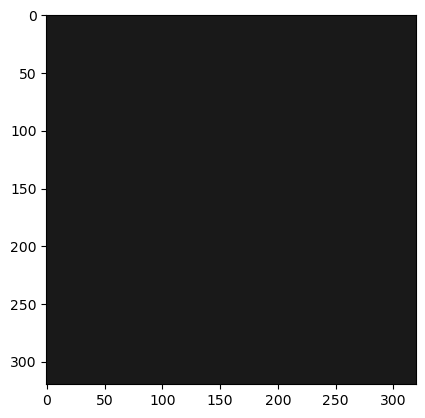

In [ ]:
###### TODO reorder k_space_density_compensation, kspace_data...

100%|██████████| 96000/96000 [00:32<00:00, 2990.28it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.